## Import the necessary libraries

In [55]:
import pandas as pd
import numpy as np
from datetime import timedelta, date
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb

## Preprocessing

In [56]:
# Load the adherence rates dataset
data = pd.read_csv('Adherence Rates.csv')

# Load the reproduction numbers dataset
repro_data = pd.read_json('Rdata.txt')

In [57]:
# Create a dataframe with only the 'Date' and 'Rt_avg' columns from the reproduction numbers dataset
repro_number = repro_data[['Date', 'Rt_avg']]

# Make sure that the Date column is in datetime format
repro_number['Date'] = pd.to_datetime(repro_number['Date'])

# Set the start and end date for the data
start_date = '2020-04-17' # The start of the first measurement moment
end_date = '2022-07-09' # The last date in the data

# Filter the dataframe to the date range
filtered_data = repro_number[(repro_number['Date'] >= start_date) & (repro_number['Date'] <= end_date)]

C:\Users\20193632\AppData\Local\Temp\ipykernel_11704\3302470508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repro_number['Date'] = pd.to_datetime(repro_number['Date'])


### Creating dataset with measuring moment as one datapoint

In [58]:
# Calculate the average reproduction number for each measurement moment on the first day of the period

# All starting dates of a testing moment of 8 days
start_dates_8 = ['2020-04-17'] #  start date of the measurement moment

# All starting dates of a testing period of 6 days
start_dates_6 = ['2020-05-07', '2020-05-26'] # start dates of the measurement moments

# All starting dates of a testing period of 5 days
start_dates_5 = ['2020-06-17', '2020-07-08', '2020-08-19', '2020-09-30', '2020-11-11', '2020-12-30', '2021-02-10','2021-03-24', '2021-05-5', '2021-06-16',
 '2021-07-28', '2021-09-08', '2021-10-20', '2021-11-24', '2022-01-19'] # the start dates of the measurement periods

# Create a new column initialized with values NaN for storing the averages
filtered_data['Rt_avg_period'] = np.nan

def calculate_rt_avg_period(filtered_data: pd.DataFrame,
                            start_date: str,
                            period_days: int) -> pd.DataFrame:
    """
    Calculates the average 'Rt_avg' over a specified number of days,
    starting from the given start_date. The result is placed in
    the 'Rt_avg_period' column at the start date. """

    # Convert start_date to datetime for comparison
    start_date_dt = pd.to_datetime(start_date)

    # Check if the start date is present in the DataFrame
    if start_date_dt in filtered_data['Date'].values:
        # Get the index of the start date
        start_idx = filtered_data[filtered_data['Date'] == start_date_dt].index[0]

        # Calculate the end index for the specified period
        # period_days is inclusive, so subtract 1 from period_days
        end_idx = start_idx + (period_days - 1)

        # Check if the end index is within the DataFrame bounds
        if end_idx < len(filtered_data):
            # Calculate average Rt_avg from start to end index (inclusive)
            avg_value = filtered_data.loc[start_idx:end_idx, 'Rt_avg'].mean()

            # Assign the calculated average to 'Rt_avg_period' at the start index
            filtered_data.loc[start_idx, 'Rt_avg_period'] = avg_value

calculate_rt_avg_period(filtered_data, start_dates_8[0], 8)

for start_date in start_dates_6:
    calculate_rt_avg_period(filtered_data, start_date, 6)

for start_date in start_dates_5:
    calculate_rt_avg_period(filtered_data, start_date, 5)

all_start_dates = ['2020-04-17', '2020-05-07', '2020-05-26', '2020-06-17', '2020-07-08', '2020-08-19', '2020-09-30', '2020-11-11', '2020-12-30', '2021-02-10','2021-03-24', '2021-05-5', '2021-06-16',
 '2021-07-28', '2021-09-08', '2021-10-20', '2021-11-24', '2022-01-19']
# Print the DataFrame to check the results for the specific start dates
print(filtered_data[filtered_data['Date'].isin(pd.to_datetime(all_start_dates))])

          Date  Rt_avg  Rt_avg_period
60  2020-04-17    0.77       0.742500
80  2020-05-07    0.82       0.796667
99  2020-05-26    0.68       0.550000
121 2020-06-17    0.85       0.958000
142 2020-07-08    1.42       1.392000
184 2020-08-19    1.06       1.114000
226 2020-09-30    1.24       1.200000
268 2020-11-11    0.99       0.988000
317 2020-12-30    0.95       0.944000
359 2021-02-10    1.06       1.126000
401 2021-03-24    0.96       0.970000
443 2021-05-05    0.86       0.856000
485 2021-06-16    0.79       0.870000
527 2021-07-28    0.84       0.898000
569 2021-09-08    0.89       0.912000
611 2021-10-20    1.16       1.198000
646 2021-11-24    0.95       0.952000
702 2022-01-19    1.14       1.124000


C:\Users\20193632\AppData\Local\Temp\ipykernel_11704\558296315.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Rt_avg_period'] = np.nan


In [59]:
# Create a seperate dataframe with the 'Rt_avg_period' column and reset the index
rt_avg_period = filtered_data['Rt_avg_period']
rt_avg_period = rt_avg_period.dropna()
rt_avg_period = rt_avg_period.reset_index(drop = True)

# Add the 'Rt_avg_period' column to the original dataset
data = pd.concat([data, rt_avg_period], axis = 1 )

# Drop the columns which are decided to not be used in the analysis
only_data = data.drop(['Testen bij klachten (2)', 'Thuisblijven bij klachten (2)',
       'Thuiswerken (3)'], axis = 1)

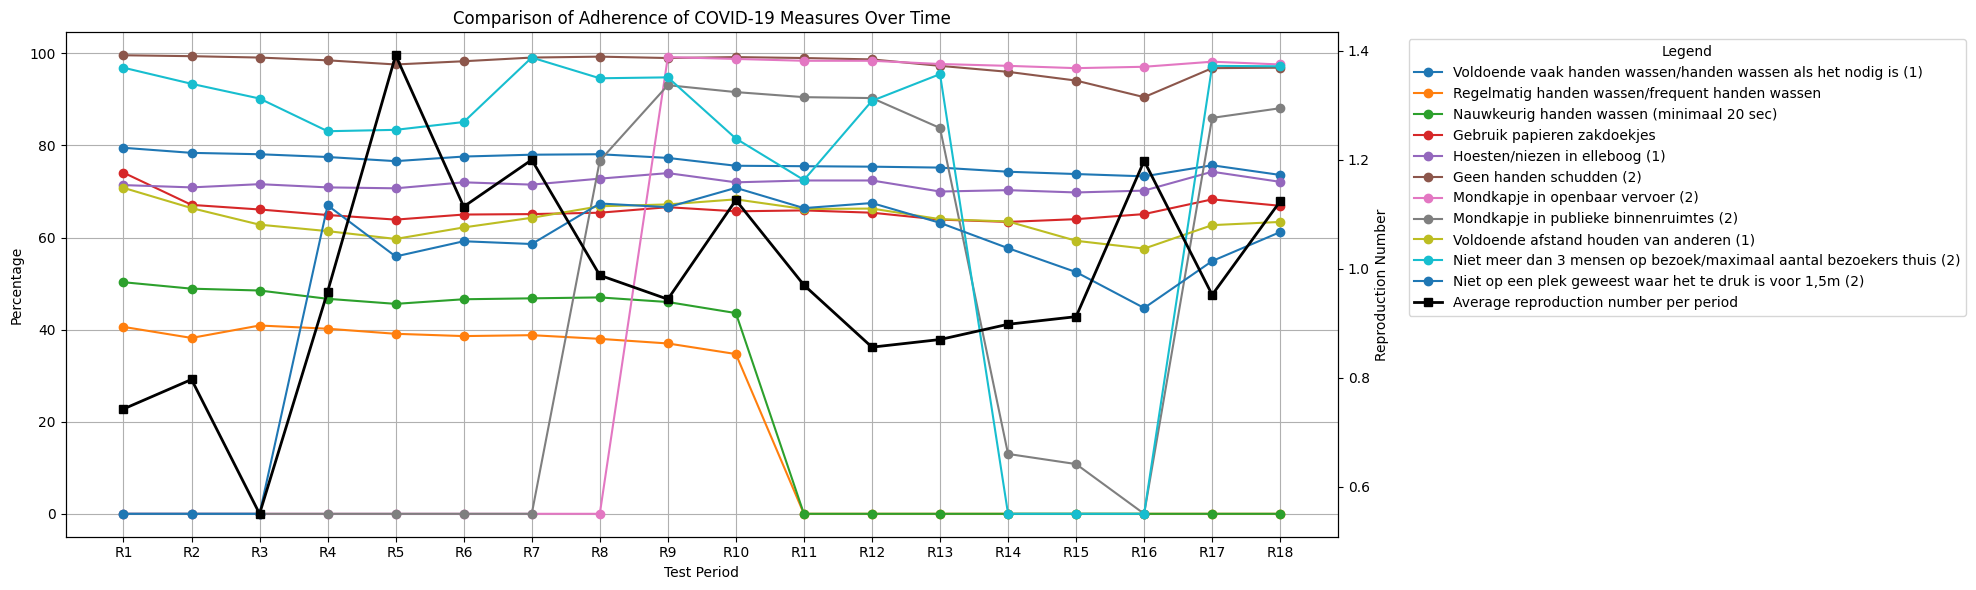

In [60]:
# Set the figure size
plt.figure(figsize=(20, 6))

# Plot the primary features
ax1 = plt.gca()  # Get current axes (ax1 is the left y-axis)

for column in only_data.columns[1:-1]:  # Skip the 'Meetronde' and 'Rt_avg_period' column
    ax1.plot(only_data['Meetronde'], only_data[column], marker='o', label=column)

# Set labels and titles for the primary y-axis
ax1.set_xlabel('Test Period')
ax1.set_ylabel('Percentage')
ax1.set_title('Comparison of Adherence of COVID-19 Measures Over Time')
ax1.grid(True)

# Create a secondary y-axis for 'Rt_avg_period'
ax2 = ax1.twinx()
ax2.plot(only_data['Meetronde'], only_data['Rt_avg_period'], 'k-', marker='s', label='Average reproduction number per period', linewidth=2)

# Set labels for the secondary y-axis
ax2.set_ylabel('Reproduction Number')

# Combine legends of both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Place the legend to the right of the plot
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

# Show the plot
plt.tight_layout()
plt.show()

### Create the clusters of measures

In [61]:
# Create clusters of measures of the same kind
cluster_data_1 = only_data

# Cluster 1: Measures regarding hand washing
cluster_data_1['Hand washing'] = cluster_data_1['Voldoende vaak handen wassen/handen wassen als het nodig is (1)']

# Cluster 2: Measures regarding personal hygiene
cluster_data_1['Personal hygiene measures'] = (cluster_data_1['Gebruik papieren zakdoekjes'] + 
    cluster_data_1['Hoesten/niezen in elleboog (1)'] + cluster_data_1['Geen handen schudden (2)']) / 3

# Cluster 3: Measures regarding wearing of facial mask
cluster_data_1['Masks'] = (cluster_data_1['Mondkapje in openbaar vervoer (2)'] + 
    cluster_data_1['Mondkapje in publieke binnenruimtes (2)']) / 2

# Cluster 3: Measures regarding wearing of keeping distance from others
cluster_data_1['Keeping distance'] = (cluster_data_1['Voldoende afstand houden van anderen (1)'] + 
    cluster_data_1['Niet op een plek geweest waar het te druk is voor 1,5m (2)'] + cluster_data_1['Niet meer dan 3 mensen op bezoek/maximaal aantal bezoekers thuis (2)']) / 3

# Drop the original measure columns
cluster_data_1 = cluster_data_1.drop(['Voldoende vaak handen wassen/handen wassen als het nodig is (1)',
 'Regelmatig handen wassen/frequent handen wassen', 'Nauwkeurig handen wassen (minimaal 20 sec)', 'Gebruik papieren zakdoekjes',
  'Hoesten/niezen in elleboog (1)', 'Geen handen schudden (2)', 'Mondkapje in openbaar vervoer (2)', 
  'Mondkapje in publieke binnenruimtes (2)', 'Voldoende afstand houden van anderen (1)', 
  'Niet op een plek geweest waar het te druk is voor 1,5m (2)', 'Niet meer dan 3 mensen op bezoek/maximaal aantal bezoekers thuis (2)'], axis = 1)

cluster_data_1

,Meetronde,Rt_avg_period,Hand washing,Personal hygiene measures,Masks,Keeping distance
0,R1,0.742500,79.5,81.700000,0.00,55.900000
1,R2,0.796667,78.4,79.133333,0.00,53.266667
2,R3,0.550000,78.1,78.933333,0.00,51.000000
3,R4,0.958000,77.5,78.100000,0.00,70.500000
4,R5,1.392000,76.6,77.400000,0.00,66.333333
5,R6,1.114000,77.6,78.433333,0.00,68.833333
6,R7,1.200000,78.0,78.566667,0.00,74.000000
7,R8,0.988000,78.1,79.166667,38.35,76.266667
8,R9,0.944000,77.3,79.866667,96.15,76.200000
9,R10,1.126000,75.6,78.966667,95.20,73.533333


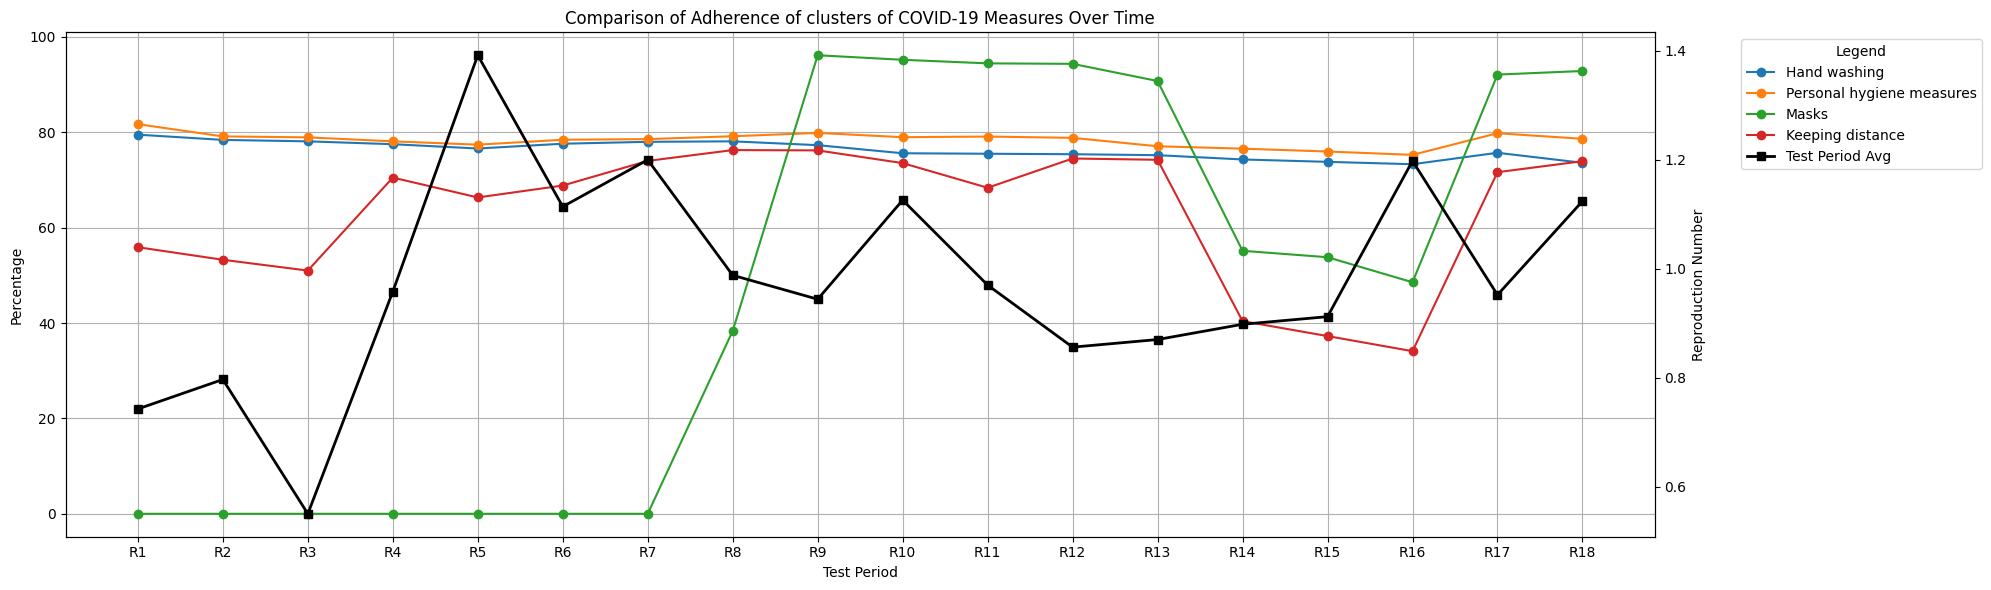

In [62]:
# Set the figure size
plt.figure(figsize=(20, 6))

# Plot the primary features
ax1 = plt.gca()  # Get current axes (ax1 is the left y-axis)

for column in cluster_data_1.columns[2:]:
    ax1.plot(cluster_data_1['Meetronde'], cluster_data_1[column], marker='o', label=column)

# Set labels and titles for the primary y-axis
ax1.set_xlabel('Test Period')
ax1.set_ylabel('Percentage')
ax1.set_title('Comparison of Adherence of clusters of COVID-19 Measures Over Time')
ax1.grid(True)

# Create a secondary y-axis for 'Rt_avg_period'
ax2 = ax1.twinx()
ax2.plot(cluster_data_1['Meetronde'], cluster_data_1['Rt_avg_period'], 'k-', marker='s', label='Test Period Avg', linewidth=2)

# Set labels for the secondary y-axis
ax2.set_ylabel('Reproduction Number')

# Combine legends of both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Place the legend to the right of the plot
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

# Show the plot
plt.tight_layout()
plt.show()

### Creating dataset using individual dates

In [63]:
# Create a new dataset with the 'Rt_avg_period' column dropped
new_dataset = data.drop(['Rt_avg_period'], axis = 1)

# Make sure that the Date column is in datetime format
repro_number['Date'] = pd.to_datetime(repro_number['Date'])

# Filter the dates from the first measuring moment onwards
start_date = '2020-04-17' # The start of the first measuring moment
end_date = '2022-01-23' # The last date of the last measuring moment

# Filter the datafram to the date range
filtered_data = repro_number[(repro_number['Date'] >= start_date) & (repro_number['Date'] <= end_date)]

all_dates = filtered_data

moment_to_date = {
    'R1': '2020-04-17', 'R2': '2020-05-07', 'R3': '2020-05-26', 'R4': '2020-06-17',
    'R5': '2020-07-08', 'R6': '2020-08-19', 'R7': '2020-09-30', 'R8': '2020-11-11',
    'R9': '2020-12-30', 'R10': '2021-02-10', 'R11': '2021-03-24', 'R12': '2021-05-05',
    'R13': '2021-06-16', 'R14': '2021-07-28', 'R15': '2021-09-08', 'R16': '2021-10-20',
    'R17': '2021-11-24', 'R18': '2022-01-19' # Map measuring moment to starting date of measuring moment
}

# Convert 'Meetronde' to 'Date' in new_dataset
new_dataset['Date'] = new_dataset['Meetronde'].map(moment_to_date)
new_dataset['Date'] = pd.to_datetime(new_dataset['Date'])  # Ensure the 'Date' column is datetime type

# Merge new_dataset with all_dates
full_data = pd.merge(all_dates, new_dataset, on='Date', how='left')

# Drop again the columns which are decided to not be used in the analysis
full_data = full_data.drop(['Meetronde', 'Testen bij klachten (2)', 'Thuisblijven bij klachten (2)',
       'Thuiswerken (3)'], axis = 1) 

full_data


C:\Users\20193632\AppData\Local\Temp\ipykernel_11704\1664767230.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repro_number['Date'] = pd.to_datetime(repro_number['Date'])


,Date,Rt_avg,Voldoende vaak handen wassen/handen wassen als het nodig is (1),Regelmatig handen wassen/frequent handen wassen,Nauwkeurig handen wassen (minimaal 20 sec),Gebruik papieren zakdoekjes,Hoesten/niezen in elleboog (1),Geen handen schudden (2),Mondkapje in openbaar vervoer (2),Mondkapje in publieke binnenruimtes (2),Voldoende afstand houden van anderen (1),Niet meer dan 3 mensen op bezoek/maximaal aantal bezoekers thuis (2),"Niet op een plek geweest waar het te druk is voor 1,5m (2)"
0,2020-04-17,0.77,79.5,40.6,50.3,74.1,71.4,99.6,0.0,0.0,70.8,96.9,0.0
1,2020-04-18,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-19,0.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-20,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-21,0.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,2022-01-19,1.14,73.6,0.0,0.0,66.9,72.1,96.9,97.6,88.1,63.4,97.2,61.2
643,2022-01-20,1.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
644,2022-01-21,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,2022-01-22,1.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# Create again clusters of measures of the same kind

# Cluster 1: Washing hands
full_data['Hand washing'] = full_data['Voldoende vaak handen wassen/handen wassen als het nodig is (1)']

# Cluster 2: Personal hygiene measures
full_data['Personal hygiene measures'] = (full_data['Gebruik papieren zakdoekjes'] + 
    full_data['Hoesten/niezen in elleboog (1)'] + full_data['Geen handen schudden (2)']) / 3

# Cluster 3: Measures regarding wearing of facial mask
full_data['Masks'] = (full_data['Mondkapje in openbaar vervoer (2)'] + 
    full_data['Mondkapje in publieke binnenruimtes (2)']) / 2

# Cluster 4: Keeping distance
full_data['Keeping distance'] = (full_data['Voldoende afstand houden van anderen (1)'] + 
    full_data['Niet op een plek geweest waar het te druk is voor 1,5m (2)'] +
    full_data['Niet meer dan 3 mensen op bezoek/maximaal aantal bezoekers thuis (2)']) / 3

# Drop the not clustered columns
full_data = full_data.drop(['Voldoende vaak handen wassen/handen wassen als het nodig is (1)', 'Regelmatig handen wassen/frequent handen wassen',
 'Nauwkeurig handen wassen (minimaal 20 sec)', 'Gebruik papieren zakdoekjes', 'Hoesten/niezen in elleboog (1)', 'Geen handen schudden (2)',
  'Mondkapje in openbaar vervoer (2)', 'Mondkapje in publieke binnenruimtes (2)', 'Voldoende afstand houden van anderen (1)',
   'Niet op een plek geweest waar het te druk is voor 1,5m (2)', 'Niet meer dan 3 mensen op bezoek/maximaal aantal bezoekers thuis (2)'], axis = 1)

full_data

,Date,Rt_avg,Hand washing,Personal hygiene measures,Masks,Keeping distance
0,2020-04-17,0.77,79.5,81.700000,0.00,55.900000
1,2020-04-18,0.75,NaN,NaN,NaN,NaN
2,2020-04-19,0.72,NaN,NaN,NaN,NaN
3,2020-04-20,0.70,NaN,NaN,NaN,NaN
4,2020-04-21,0.72,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
642,2022-01-19,1.14,73.6,78.633333,92.85,73.933333
643,2022-01-20,1.14,NaN,NaN,NaN,NaN
644,2022-01-21,1.13,NaN,NaN,NaN,NaN
645,2022-01-22,1.12,NaN,NaN,NaN,NaN


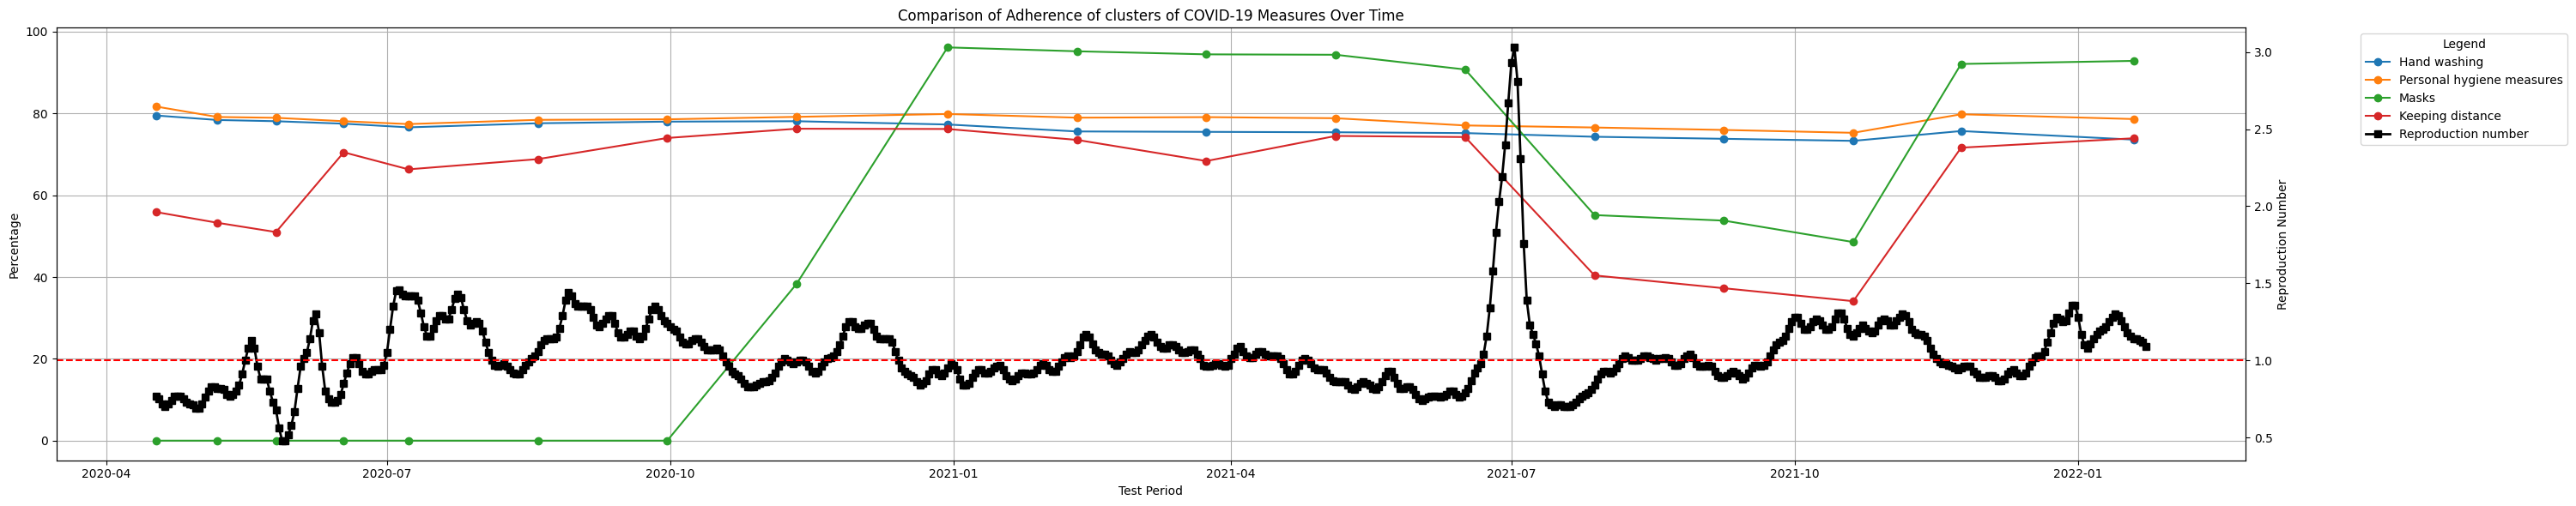

In [65]:
column_to_plot = ['Hand washing', 'Personal hygiene measures', 'Masks', 'Keeping distance']

# Set the figure size
plt.figure(figsize=(30, 6))

# Plotting the primary features
ax1 = plt.gca()  # Get current axes (ax1 is the left y-axis)

for column in full_data.columns[2:]:
    valid_data = full_data.dropna(subset=[column])
    ax1.plot(valid_data['Date'], valid_data[column], marker='o', label=column)

# Set labels and titles for the primary y-axis
ax1.set_xlabel('Test Period')
ax1.set_ylabel('Percentage')
ax1.set_title('Comparison of Adherence of clusters of COVID-19 Measures Over Time')
ax1.grid(True)

# Create a secondary y-axis for 'Rt_avg'
ax2 = ax1.twinx()
ax2.plot(full_data['Date'], full_data['Rt_avg'], 'k-', marker='s', label='Reproduction number', linewidth=2)

# Set labels for the secondary y-axis
ax2.set_ylabel('Reproduction Number')

# Adding legends
# Combine legends of both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Add a horizontal line at Rt_avg = 1
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Rt_avg = 1')

# Place the legend to the right of the plot
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

# Show the plot
plt.tight_layout()
plt.show()

## Generating more data points

### Setting the adherence rates of each measuring moment to each date in these moments

In [66]:
# Define a function to fill the measuring moments with the average adherence rates
def fill_moments(data, start_date, end_date, columns):
    """
    Sets for each day in a measuring moment the adherence rate for each cluster to the average adherence rates for that measuring moment.

    Arguments:
    data (pd.DataFrame): DataFrame containing the data.
    start_date (str): Start date for the measuring moment ('YYYY-MM-DD' format).
    end_date (str): End date for the measuring moment ('YYYY-MM-DD' format).
    columns (list): List of column names.
    """
    # Convert strings to datetime objects
    start_datetime = pd.to_datetime(start_date)
    end_datetime = pd.to_datetime(end_date)

    # Create a mask for the given date range
    mask = (data['Date'] >= start_datetime) & (data['Date'] <= end_datetime)

    # Ensure the start date values are not NaN and copy them across the range
    if not data.loc[data['Date'] == start_datetime, columns].isna().any().any():
        data.loc[mask, columns] = data.loc[mask, columns].apply(lambda x: x.where(data['Date'] == start_datetime))

    # Apply forward fill within the date range
    data.loc[mask, columns] = data.loc[mask, columns].ffill()

In [67]:
# Define the start and end dates for each measuring moment
start_dates = ['2020-04-17', '2020-05-07', '2020-05-26', '2020-06-17', '2020-07-08', '2020-08-19', '2020-09-30', '2020-11-11', '2020-12-30', '2021-02-10','2021-03-24',
 '2021-05-05', '2021-06-16', '2021-07-28', '2021-09-08', '2021-10-20', '2021-11-24', '2022-01-19']
end_dates = ['2020-04-24', '2020-05-12', '2020-06-01', '2020-06-21', '2020-07-12', '2020-08-23', '2020-10-04', '2020-11-15', '2021-01-03', '2021-02-14', '2021-03-28',
 '2021-05-09', '2021-06-20', '2021-08-01', '2021-09-12', '2021-10-24', '2021-11-28', '2022-01-23']

# Define the columns to fill
cols_to_fill = ['Hand washing', 'Personal hygiene measures', 'Masks', 'Keeping distance']

# Fill the measuring moments with the average reproduction number
for start_date, end_date in zip(start_dates, end_dates):
    fill_moments(full_data, start_date, end_date, cols_to_fill)

In [68]:
# Set 'Date' as the DataFrame index
full_data.set_index('Date', inplace=True)

### Interpolate between measuring moment 12 and 13 to generate more data points

In [69]:
# Define the period for interpolation
start_date = '2021-05-09'
end_date = '2021-06-16'
columns = ['Hand washing', 'Personal hygiene measures', 'Masks', 'Keeping distance']

# Extract values on start and end dates
start_values = full_data.loc[start_date, columns]
end_values = full_data.loc[end_date, columns]

# Calculate the difference and the number of days between the two dates
difference = end_values - start_values
days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days

# Compute steps of daily increment
daily_increment = difference / days

# Create a date range between start and end dates
date_range = pd.date_range(start_date, end_date, freq='D')

# Initialize the date immediately after start_date
current_date = pd.to_datetime(start_date) + pd.Timedelta(days=1)

# Loop over the date range and apply the daily increment
for single_date in date_range[1:-1]:  # Exclude the first and last day since they are already set
    full_data.loc[single_date, columns] = full_data.loc[current_date - pd.Timedelta(days=1), columns] + daily_increment
    current_date += pd.Timedelta(days=1)

# Print the updated DataFrame section to verify
print(full_data.loc[start_date: end_date, columns])


            Hand washing  Personal hygiene measures      Masks  \
Date                                                             
2021-05-09     75.400000                  78.833333  94.350000   
2021-05-10     75.394737                  78.786842  94.255263   
2021-05-11     75.389474                  78.740351  94.160526   
2021-05-12     75.384211                  78.693860  94.065789   
2021-05-13     75.378947                  78.647368  93.971053   
2021-05-14     75.373684                  78.600877  93.876316   
2021-05-15     75.368421                  78.554386  93.781579   
2021-05-16     75.363158                  78.507895  93.686842   
2021-05-17     75.357895                  78.461404  93.592105   
2021-05-18     75.352632                  78.414912  93.497368   
2021-05-19     75.347368                  78.368421  93.402632   
2021-05-20     75.342105                  78.321930  93.307895   
2021-05-21     75.336842                  78.275439  93.213158   
2021-05-22

In [70]:
# Reset the index to convert 'Date' back into a column
full_data.reset_index(inplace=True)
full_data

,Date,Rt_avg,Hand washing,Personal hygiene measures,Masks,Keeping distance
0,2020-04-17,0.77,79.5,81.700000,0.00,55.900000
1,2020-04-18,0.75,79.5,81.700000,0.00,55.900000
2,2020-04-19,0.72,79.5,81.700000,0.00,55.900000
3,2020-04-20,0.70,79.5,81.700000,0.00,55.900000
4,2020-04-21,0.72,79.5,81.700000,0.00,55.900000
...,...,...,...,...,...,...
642,2022-01-19,1.14,73.6,78.633333,92.85,73.933333
643,2022-01-20,1.14,73.6,78.633333,92.85,73.933333
644,2022-01-21,1.13,73.6,78.633333,92.85,73.933333
645,2022-01-22,1.12,73.6,78.633333,92.85,73.933333


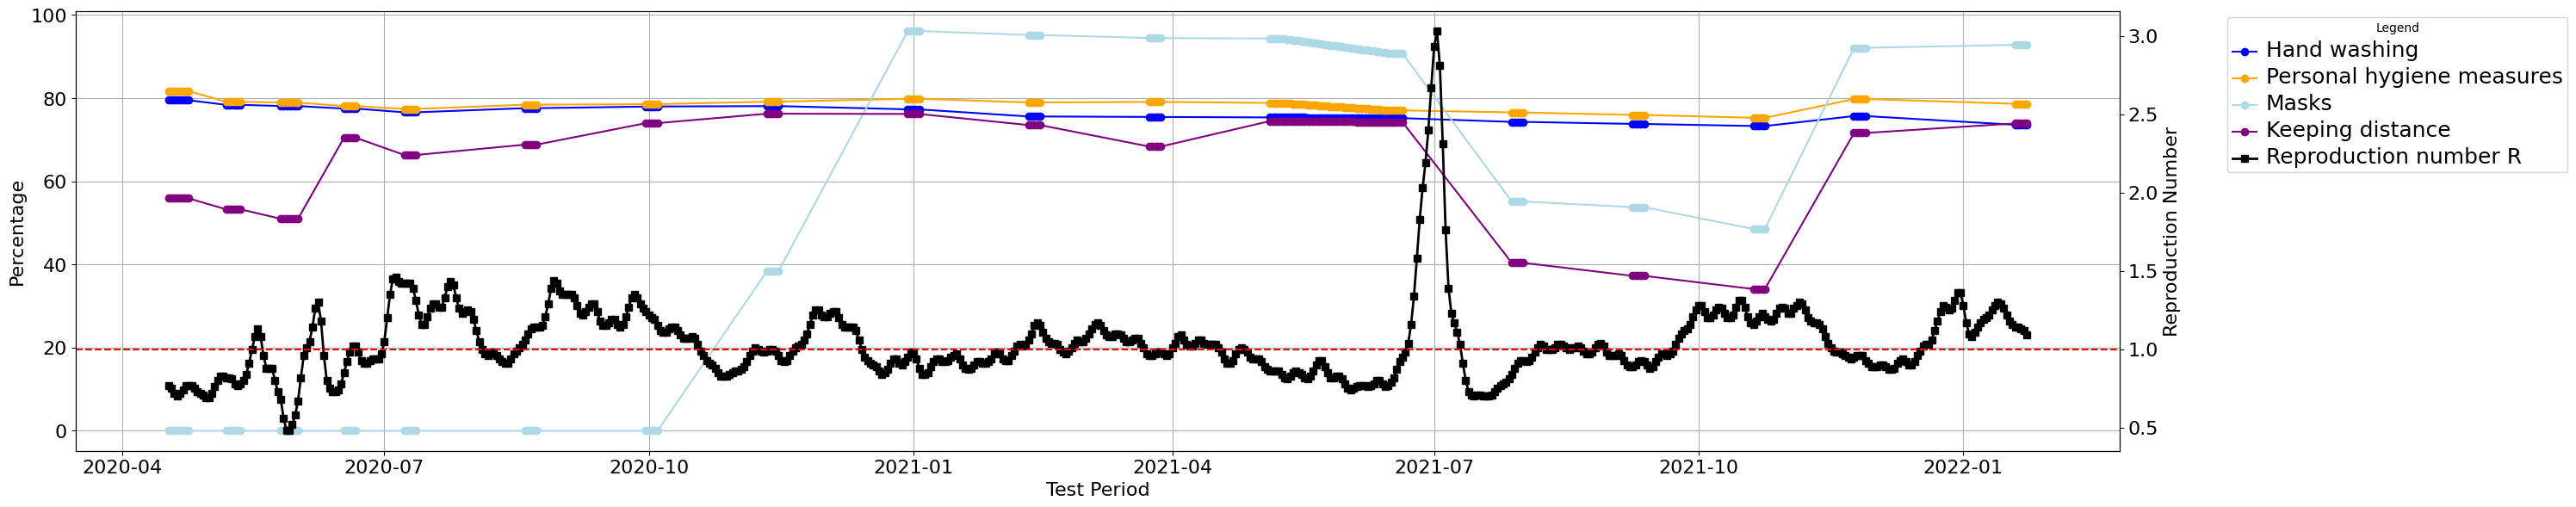

In [71]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(30, 6))

# Plot the primary features
ax1 = plt.gca()  # Get current axes (ax1 is the left y-axis)
plt.yticks(fontsize=16)

# Defining colors for each measure
color_map = {
    'Hand washing': 'blue',  # Normal blue for Hand washing
    'Personal hygiene measures': 'orange',  # Orange for Personal hygiene measures
    'Masks': 'lightblue',  # Light blue for Masks
    'Keeping distance': 'purple'  # Purple for Keeping distance
}

for column in column_to_plot:
    valid_data = full_data.dropna(subset=[column])
    ax1.plot(valid_data['Date'], valid_data[column], marker='o', label=column, color=color_map[column])

# Enlarge the font of the tick labels on the x-axis
plt.xticks(fontsize=16)

# Set labels and titles for the primary y-axis
ax1.set_xlabel('Test Period', fontsize=16)
ax1.set_ylabel('Percentage', fontsize=16)
ax1.grid(True)

# Create a secondary y-axis for 'testperiod_avg'
ax2 = ax1.twinx()
ax2.plot(full_data['Date'], full_data['Rt_avg'], 'k-', marker='s', label='Reproduction number R', linewidth=2)

# Set labels for the secondary y-axis and enlarge the font
ax2.set_ylabel('Reproduction Number', fontsize=16)

# Adding legends
# Combine legends of both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Add a horizontal line at Rt_avg = 1
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Rt_avg = 1')

# Place the legend to the right of the plot
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

# Enlarge legend text
plt.setp(ax2.get_legend().get_texts(), fontsize='18')

# Enlarge the tick labels
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()

# Save the plot
plt.savefig('Clusters over time right colors.png')

## Linear regression model

In [72]:
# Drop the NaN values
cleaned_data = full_data.dropna(subset=['Rt_avg', 'Hand washing', 'Personal hygiene measures', 'Masks', 'Keeping distance'])

In [73]:
#preview
features = cleaned_data.columns[2:6]
target = cleaned_data.columns[1]

#X and y values
X = cleaned_data[features].values
y = cleaned_data[target].values

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the dimensions of the train and test sets
print("The dimension of X_train is {}".format(X_train.shape))
print("The dimension of X_test is {}".format(X_test.shape))

#Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Adding a constant to the model for statsmodels
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
X_sm = sm.add_constant(X)

# Fit the model using sklearn for prediction
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Actual vs Prediction Scoring using sklearn
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print("\nLinear Regression Model............................................\n")
print("The train score for lr model is {}".format(train_score_lr))
print("The test score for lr model is {}".format(test_score_lr))

# Fit the model using statsmodels for detailed statistics
model_sm = sm.OLS(y, X_sm).fit()

# Print the summary of the model from statsmodels
print(model_sm.summary())

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

# Print the metrics
print("\nPerformance Metrics")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r_squared}")

sd_error = model_sm.bse[1]
sd_error

The dimension of X_train is (93, 4)
The dimension of X_test is (40, 4)

Linear Regression Model............................................

The train score for lr model is 0.36336091066593734
The test score for lr model is 0.40415833309563887
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     21.72
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           1.07e-13
Time:                        11:41:01   Log-Likelihood:                 71.778
No. Observations:                 133   AIC:                            -133.6
Df Residuals:                     128   BIC:                            -119.1
Df Model:                           4                                         
Covariance Type:            nonrobust        

np.float64(0.02338509684369407)

### Perform the linear regression for all folds

In [74]:
# Define the features and the target
X = cleaned_data[['Hand washing', 'Personal hygiene measures', 'Masks', 'Keeping distance']]
y = cleaned_data['Rt_avg']

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize scaler
scaler = StandardScaler()

# Prepare to collect metrics
mse_scores = []
rmse_scores = []
mae_scores = []
r_squared_scores = []

# Prepare to collect coefficients
washing_hands_coef = []
personal_measures_coef = []
masks_coef = []
social_distance_coef = []

# Prepare to collect standard errors
washing_hands_sd_error = []
personal_measures_sd_error = []
masks_sd_error = []
social_distance_sd_error = []

# Prepare to collect p-values
washing_hands_p_values = []
personal_measures_p_values = []
masks_p_values = []
social_distance_p_values = []

# Prepare to collect lower bounds of confidence intervals
washing_hands_ci_lower = []
personal_measures_ci_lower = []
masks_ci_lower = []
social_distance_ci_lower = []

# Prepare to collect upper bounds of confidence intervals
washing_hands_ci_upper = []
personal_measures_ci_upper = []
masks_ci_upper = []
social_distance_ci_upper = []

for train_index, test_index in kf.split(X):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Add constant for statsmodels
    X_train_sm = sm.add_constant(X_train_scaled)
    X_test_sm = sm.add_constant(X_test_scaled)

    # Fit the model using statsmodels
    model = sm.OLS(y_train, X_train_sm).fit()

    # Predict
    y_pred = model.predict(X_test_sm)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    # Store coefficients
    washing_hands_coef.append(model.params[1])
    personal_measures_coef.append(model.params[2])
    masks_coef.append(model.params[3])
    social_distance_coef.append(model.params[4])

    # Store standard errors
    washing_hands_sd_error.append(model.bse[1])
    personal_measures_sd_error.append(model.bse[2])
    masks_sd_error.append(model.bse[3])
    social_distance_sd_error.append(model.bse[4])
    
    # Store p-values
    washing_hands_p_values.append(model.pvalues[1])
    personal_measures_p_values.append(model.pvalues[2])
    masks_p_values.append(model.pvalues[3])
    social_distance_p_values.append(model.pvalues[4])

    # Store lower bounds of confidence intervals
    washing_hands_ci_lower.append(model.conf_int()[0][1])
    personal_measures_ci_lower.append(model.conf_int()[0][2])
    masks_ci_lower.append(model.conf_int()[0][3])
    social_distance_ci_lower.append(model.conf_int()[0][4])

    # Store upper bounds of confidence intervals
    washing_hands_ci_upper.append(model.conf_int()[1][1])
    personal_measures_ci_upper.append(model.conf_int()[1][2])
    masks_ci_upper.append(model.conf_int()[1][3])
    social_distance_ci_upper.append(model.conf_int()[1][4])

    # Store metrics
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r_squared_scores.append(r_squared)

# Calculate average of each metric across all folds
average_mse = np.mean(mse_scores)
average_rmse = np.mean(rmse_scores)
average_mae = np.mean(mae_scores)
average_r_squared = np.mean(r_squared_scores)

# Calculate summary statistics for each variables
average_statistics_hand_washing = [np.mean(washing_hands_coef), np.mean(washing_hands_sd_error), np.mean(washing_hands_p_values), np.mean(washing_hands_ci_lower), np.mean(washing_hands_ci_upper)]
average_statistics_personal_measures = [np.mean(personal_measures_coef), np.mean(personal_measures_sd_error), np.mean(personal_measures_p_values), np.mean(personal_measures_ci_lower), np.mean(personal_measures_ci_upper)]
average_statistics_masks = [np.mean(masks_coef), np.mean(masks_sd_error), np.mean(masks_p_values), np.mean(masks_ci_lower), np.mean(masks_ci_upper)]
average_statistics_social_distance = [np.mean(social_distance_coef), np.mean(social_distance_sd_error), np.mean(social_distance_p_values), np.mean(social_distance_ci_lower), np.mean(social_distance_ci_upper)]

# Print the metrics
print("\nAverage Performance Metrics Across All Folds:")
print(f"Average Mean Squared Error: {average_mse}")
print(f"Average Root Mean Squared Error: {average_rmse}")
print(f"Average Mean Absolute Error: {average_mae}")
print(f"Average R-squared: {average_r_squared}")
print(f"All R-squared values: {r_squared_scores}")

# Print the summary statistics for each variable
print("\nAverage Summary Statistics for Each Variable:")
print("The average coefficient for 'Hand washing' is {:.2f}".format(average_statistics_hand_washing[0]))
print("The average standard error for 'Hand washing' is {:.2f}".format(average_statistics_hand_washing[1]))
print("The average p-value for 'Hand washing' is {:.2f}".format(average_statistics_hand_washing[2]))
print("The average lower bound of the confidence interval for 'Hand washing' is {:.2f}".format(average_statistics_hand_washing[3]))
print("The average upper bound of the confidence interval for 'Hand washing' is {:.2f}".format(average_statistics_hand_washing[4]))
print("\nThe average coefficient for 'Personal hygiene measures' is {:.2f}".format(average_statistics_personal_measures[0]))
print("The average standard error for 'Personal hygiene measures' is {:.2f}".format(average_statistics_personal_measures[1]))
print("The average p-value for 'Personal hygiene measures' is {:.2f}".format(average_statistics_personal_measures[2]))
print("The average lower bound of the confidence interval for 'Personal hygiene measures' is {:.2f}".format(average_statistics_personal_measures[3]))
print("The average upper bound of the confidence interval for 'Personal hygiene measures' is {:.2f}".format(average_statistics_personal_measures[4]))
print("\nThe average coefficient for 'Masks' is {:.2f}".format(average_statistics_masks[0]))
print("The average standard error for 'Masks' is {:.2f}".format(average_statistics_masks[1]))
print("The average p-value for 'Masks' is {:.2f}".format(average_statistics_masks[2]))
print("The average lower bound of the confidence interval for 'Masks' is {:.2f}".format(average_statistics_masks[3]))
print("The average upper bound of the confidence interval for 'Masks' is {:.2f}".format(average_statistics_masks[4]))
print("\nThe average coefficient for 'Keeping distance' is {:.2f}".format(average_statistics_social_distance[0]))
print("The average standard error for 'Keeping distance' is {:.2f}".format(average_statistics_social_distance[1]))
print("The average p-value for 'Keeping distance' is {:.2f}".format(average_statistics_social_distance[2]))
print("The average lower bound of the confidence interval for 'Keeping distance' is {:.2f}".format(average_statistics_social_distance[3]))
print("The average upper bound of the confidence interval for 'Keeping distance' is {:.2f}".format(average_statistics_social_distance[4]))
changed_r_squared = np.mean([0.458756712661465, 0.24942059807329042, 0.4358149408428813, 0.39074792694121396])
print(changed_r_squared)


Average Performance Metrics Across All Folds:
Average Mean Squared Error: 0.023064087614277452
Average Root Mean Squared Error: 0.15128904355346187
Average Mean Absolute Error: 0.1220999724743621
Average R-squared: 0.10001357300481692
All R-squared values: [0.458756712661465, 0.24942059807329042, 0.4358149408428813, -1.0346723134947662, 0.39074792694121396]

Average Summary Statistics for Each Variable:
The average coefficient for 'Hand washing' is -0.28
The average standard error for 'Hand washing' is 0.04
The average p-value for 'Hand washing' is 0.00
The average lower bound of the confidence interval for 'Hand washing' is -0.36
The average upper bound of the confidence interval for 'Hand washing' is -0.19

The average coefficient for 'Personal hygiene measures' is 0.06
The average standard error for 'Personal hygiene measures' is 0.03
The average p-value for 'Personal hygiene measures' is 0.02
The average lower bound of the confidence interval for 'Personal hygiene measures' is 0.0

C:\Users\20193632\AppData\Local\Temp\ipykernel_11704\1305652424.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  washing_hands_coef.append(model.params[1])
C:\Users\20193632\AppData\Local\Temp\ipykernel_11704\1305652424.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  personal_measures_coef.append(model.params[2])
C:\Users\20193632\AppData\Local\Temp\ipykernel_11704\1305652424.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

## XGBoost regression model

In [75]:
cleaned_data

,Date,Rt_avg,Hand washing,Personal hygiene measures,Masks,Keeping distance
0,2020-04-17,0.77,79.5,81.700000,0.00,55.900000
1,2020-04-18,0.75,79.5,81.700000,0.00,55.900000
2,2020-04-19,0.72,79.5,81.700000,0.00,55.900000
3,2020-04-20,0.70,79.5,81.700000,0.00,55.900000
4,2020-04-21,0.72,79.5,81.700000,0.00,55.900000
...,...,...,...,...,...,...
642,2022-01-19,1.14,73.6,78.633333,92.85,73.933333
643,2022-01-20,1.14,73.6,78.633333,92.85,73.933333
644,2022-01-21,1.13,73.6,78.633333,92.85,73.933333
645,2022-01-22,1.12,73.6,78.633333,92.85,73.933333


### Calculate the evaluation metrics and predict the reproduction number for the couterfactual situations

In [76]:
# Calculate the interpolated adherence rate values between 20-06-2021 and 24-11-2021 for the clusters 'Masks' and 'Keeping distance'

# Check begin values at 20-06-2021
start_value_masks = cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-06-16'), 'Masks'].values[0]
start_value_keeping_distance = cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-06-16'), 'Keeping distance'].values[0]

# Check end value at 24-11-2021
end_value_masks = cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-11-24'), 'Masks'].values[0]
end_value_keeping_distance = cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-11-24'), 'Keeping distance'].values[0]

# Calculate the difference between the start and end values
difference_masks = end_value_masks - start_value_masks
difference_keeping_distance = end_value_keeping_distance - start_value_keeping_distance
steps_masks = difference_masks / 4 # Devide the difference by 4 measuring moments
steps_keeping_distance = difference_keeping_distance / 4 

# Create a list to store the interpolated values
interpolated_values_masks = []
interpolated_values_keeping_distance = []

# Calculate the interpolated values
for i in range(1, 4): # The last value is the 17th measuring moment and is already known
    interpolated_value_masks = start_value_masks + i * steps_masks
    interpolated_values_masks.append(interpolated_value_masks)
    
    interpolated_value_keeping_distance = start_value_keeping_distance + i * steps_keeping_distance
    interpolated_values_keeping_distance.append(interpolated_value_keeping_distance)

# Create a list of the adherence rates of measuring moment 14-16 for each cluster to be used as input for the model
input_hand_washing = [cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-08-01'), 'Hand washing'].values[0],
cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-09-08'), 'Hand washing'].values[0],
cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-10-20'), 'Hand washing'].values[0]]

input_personal_measures = [cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-08-01'), 'Personal hygiene measures'].values[0],
cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-09-08'), 'Personal hygiene measures'].values[0],
cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-10-20'), 'Personal hygiene measures'].values[0]]

input_masks = [cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-08-01'), 'Masks'].values[0],
cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-09-08'), 'Masks'].values[0],
cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-10-20'), 'Masks'].values[0]]

input_keeping_distance = [cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-08-01'), 'Keeping distance'].values[0],
cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-09-08'), 'Keeping distance'].values[0],
cleaned_data.loc[cleaned_data['Date'] == pd.Timestamp('2021-10-20'), 'Keeping distance'].values[0]]


In [77]:
# Set the features and target variable
X = cleaned_data[['Hand washing', 'Personal hygiene measures', 'Masks', 'Keeping distance']]
y = cleaned_data['Rt_avg']

# Set up the parameters for xgboost
xgb_params = {
    'objective': 'reg:squarederror',  # Use reg:squarederror for regression tasks
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100  # Modify this based on your requirement and computational resources
}

# Set the number of k-folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the MSE, RMSE, MAE and R-squared scores for each fold	
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# Initialize lists to store the feature importances for each fold
feature_importances = []

# Initialize list to store the reproduction number for each fold
reproduction_number = []

# Initialize lists to store the prediction for the case without interpolation
no_interpolation_0 = []
no_interpolation_1 = []
no_interpolation_2 = []

# Initialize lists to store the prediction for the case with interpolation for Masks
interpolation_masks_0 = []
interpolation_masks_1 = []
interpolation_masks_2 = []

# Initialize lists to store the prediction for the case with interpolation for Keeping distance
interpolation_keeping_distance_0 = []
interpolation_keeping_distance_1 = []
interpolation_keeping_distance_2 = []

# Initialize lists to store the prediction for the case with interpolation for both Masks and Keeping distance
interpolation_both_0 = []
interpolation_both_1 = []
interpolation_both_2 = []

# Loop through each fold and train the model
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Calculate the MSE and MAE for this fold
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Append the scores to the lists
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    # Append the feature importances to the list
    feature_importances.append(model.feature_importances_)

    # Calculate the input data for the situation prediction
    handen_wassen_mean = X_test['Hand washing'].mean()
    persoonlijke_maatregelen_mean = X_test['Personal hygiene measures'].mean()
    mondkapjes_mean = X_test['Masks'].mean()
    afstand_houden_mean = X_test['Keeping distance'].mean()

    # Predict the situation for the case without interpolation
    for i in range(0, 3):
        input_data = pd.DataFrame({
            'Hand washing': [input_hand_washing[i]],
            'Personal hygiene measures': [input_personal_measures[i]],
            'Masks': [input_masks[i]],
            'Keeping distance': [input_keeping_distance[i]]
        })

        # Append the situation prediction to the respective list in a compact way
        situation = model.predict(input_data)
        globals()[f'no_interpolation_{i}'].append(situation)

    # Predict the situation for the case with interpolation for Masks
    for i in range(0, 3):
        input_data = pd.DataFrame({
            'Hand washing': [input_hand_washing[i]],
            'Personal hygiene measures': [input_personal_measures[i]],
            'Masks': [interpolated_values_masks[i]],
            'Keeping distance': [input_keeping_distance[i]]
        })

        # Append the situation prediction to the respective list in a compact way
        situation = model.predict(input_data)
        globals()[f'interpolation_masks_{i}'].append(situation)
    
    # Predict the situation for the case with interpolation for Keeping distance
    for i in range(0, 3):
        input_data = pd.DataFrame({
            'Hand washing': [input_hand_washing[i]],
            'Personal hygiene measures': [input_personal_measures[i]],
            'Masks': [input_masks[i]],
            'Keeping distance': [interpolated_values_keeping_distance[i]]
        })

        # Append the situation prediction to the respective list in a compact way
        situation = model.predict(input_data)
        globals()[f'interpolation_keeping_distance_{i}'].append(situation)
    
    # Predict the the situation for the case with interpolation for both Masks and Keeping distance
    for i in range(0, 3):
        input_data = pd.DataFrame({
            'Hand washing': [input_hand_washing[i]],
            'Personal hygiene measures': [input_personal_measures[i]],
            'Masks': [interpolated_values_masks[i]],
            'Keeping distance': [interpolated_values_keeping_distance[i]]
        })

        # Append the situation prediction to the respective list in a compact way
        situation = model.predict(input_data)
        globals()[f'interpolation_both_{i}'].append(situation)
    
    # Predict the average reproduction number for the test set
    input_data = pd.DataFrame({
        'Hand washing': [handen_wassen_mean],
        'Personal hygiene measures': [persoonlijke_maatregelen_mean],
        'Masks': [mondkapjes_mean],
        'Keeping distance': [afstand_houden_mean]
    })
    
    # Append the situation prediction to the respective list in a compact way
    situation = model.predict(input_data)
    reproduction_number.append(situation)


# Calculate average MSE and MAE across all folds
average_mse = np.mean(mse_scores)
average_rmse = np.mean(rmse_scores)
average_mae = np.mean(mae_scores)
average_r2 = np.mean(r2_scores)

# Calculate average feature importances across all folds
average_feature_importances = np.mean(feature_importances, axis=0)

# Calculate average reproduction number across all folds
average_reproduction_number = np.mean(reproduction_number)

# Calculate average situation prediction for the case without interpolation
average_no_interpolation_14 = np.mean(no_interpolation_0)
average_no_interpolation_15 = np.mean(no_interpolation_1)
average_no_interpolation_16 = np.mean(no_interpolation_2)

# Calculate average situation prediction for the case with interpolation for Masks
average_interpolation_masks_14 = np.mean(interpolation_masks_0)
average_interpolation_masks_15 = np.mean(interpolation_masks_1)
average_interpolation_masks_16 = np.mean(interpolation_masks_2)

# Calculate average situation prediction for the case with interpolation for Keeping distance
average_interpolation_keeping_distance_14 = np.mean(interpolation_keeping_distance_0)
average_interpolation_keeping_distance_15 = np.mean(interpolation_keeping_distance_1)
average_interpolation_keeping_distance_16 = np.mean(interpolation_keeping_distance_2)

# Calculate average situation prediction for the case with interpolation for both Masks and Keeping distance
average_interpolation_both_14 = np.mean(interpolation_both_0)
average_interpolation_both_15 = np.mean(interpolation_both_1)
average_interpolation_both_16 = np.mean(interpolation_both_2)

# Print the average MSE and MAE
print(f"Average Mean Squared Error: {average_mse}")
print(f"Average Root Mean Squared Error: {average_rmse}")
print(f"Average Mean Absolute Error: {average_mae}")
print(f"Average R2 Score: {average_r2}")

# Print the average feature importances
print(f"Average feature importances: {average_feature_importances}")

# Print the average reproduction number
print(f"Average reproduction number: {average_reproduction_number}")

# Print the average situation prediction for the case without interpolation
print(f"Average situation prediction for the case without interpolation for measuring moment 14: {average_no_interpolation_14}")
print(f"Average situation prediction for the case without interpolation for measuring moment 15: {average_no_interpolation_15}")
print(f"Average situation prediction for the case without interpolation for measuring moment 16: {average_no_interpolation_16}")

# Print the average situation prediction for the case with interpolation for Masks
print(f"Average situation prediction for the case with interpolation for Masks for measuring moment 14: {average_interpolation_masks_14}")
print(f"Average situation prediction for the case with interpolation for Masks for measuring moment 15: {average_interpolation_masks_15}")
print(f"Average situation prediction for the case with interpolation for Masks for measuring moment 16: {average_interpolation_masks_16}")

# Print the average situation prediction for the case with interpolation for Keeping distance
print(f"Average situation prediction for the case with interpolation for Keeping distance for measuring moment 14: {average_interpolation_keeping_distance_14}")
print(f"Average situation prediction for the case with interpolation for Keeping distance for measuring moment 15: {average_interpolation_keeping_distance_15}")
print(f"Average situation prediction for the case with interpolation for Keeping distance for measuring moment 16: {average_interpolation_keeping_distance_16}")

# Print the average situation prediction for the case with interpolation for both Masks and Keeping distance
print(f"Average situation prediction for the case with interpolation for both Masks and Keeping distance for measuring moment 14: {average_interpolation_both_14}")
print(f"Average situation prediction for the case with interpolation for both Masks and Keeping distance for measuring moment 15: {average_interpolation_both_15}")
print(f"Average situation prediction for the case with interpolation for both Masks and Keeping distance for measuring moment 16: {average_interpolation_both_16}")

Average Mean Squared Error: 0.0018619063599298908
Average Root Mean Squared Error: 0.0416714707687981
Average Mean Absolute Error: 0.030060465295090627
Average R2 Score: 0.93486237232761
Average feature importances: [0.10640742 0.10362603 0.31798834 0.47197825]
Average reproduction number: 0.9890483021736145
Average situation prediction for the case without interpolation for measuring moment 14: 0.8961812257766724
Average situation prediction for the case without interpolation for measuring moment 15: 0.9125849008560181
Average situation prediction for the case without interpolation for measuring moment 16: 1.1980865001678467
Average situation prediction for the case with interpolation for Masks for measuring moment 14: 0.8948659896850586
Average situation prediction for the case with interpolation for Masks for measuring moment 15: 0.9142976999282837
Average situation prediction for the case with interpolation for Masks for measuring moment 16: 1.0125327110290527
Average situation pre

In [78]:
# Calculate difference in reproduction number between the case without interpolation and the case with interpolation for Masks
difference_masks_14 = average_no_interpolation_14 - average_interpolation_masks_14
difference_masks_15 = average_no_interpolation_15 - average_interpolation_masks_15
difference_masks_16 = average_no_interpolation_16 - average_interpolation_masks_16

# Calculate difference in reproduction number between the case without interpolation and the case with interpolation for Keeping distance
difference_keeping_distance_14 = average_no_interpolation_14 - average_interpolation_keeping_distance_14
difference_keeping_distance_15 = average_no_interpolation_15 - average_interpolation_keeping_distance_15
difference_keeping_distance_16 = average_no_interpolation_16 - average_interpolation_keeping_distance_16

# Calculate difference in reproduction number between the case without interpolation and the case with interpolation for both Masks and Keeping distance
difference_both_14 = average_no_interpolation_14 - average_interpolation_both_14
difference_both_15 = average_no_interpolation_15 - average_interpolation_both_15
difference_both_16 = average_no_interpolation_16 - average_interpolation_both_16

# Print the difference in reproduction number between the case without interpolation and the case with interpolation for Masks
print(f"Difference in reproduction number for the case with interpolation for Masks for measuring moment 14: {difference_masks_14}")
print(f"Difference in reproduction number for the case with interpolation for Masks for measuring moment 15: {difference_masks_15}")
print(f"Difference in reproduction number for the case with interpolation for Masks for measuring moment 16: {difference_masks_16}")

# Print the difference in reproduction number between the case without interpolation and the case with interpolation for Keeping distance
print(f"Difference in reproduction number for the case with interpolation for Keeping distance for measuring moment 14: {difference_keeping_distance_14}")
print(f"Difference in reproduction number for the case with interpolation for Keeping distance for measuring moment 15: {difference_keeping_distance_15}")
print(f"Difference in reproduction number for the case with interpolation for Keeping distance for measuring moment 16: {difference_keeping_distance_16}")

# Print the difference in reproduction number between the case without interpolation and the case with interpolation for both Masks and Keeping distance
print(f"Difference in reproduction number for the case with interpolation for both Masks and Keeping distance for measuring moment 14: {difference_both_14}")
print(f"Difference in reproduction number for the case with interpolation for both Masks and Keeping distance for measuring moment 15: {difference_both_15}")
print(f"Difference in reproduction number for the case with interpolation for both Masks and Keeping distance for measuring moment 16: {difference_both_16}")


Difference in reproduction number for the case with interpolation for Masks for measuring moment 14: 0.0013152360916137695
Difference in reproduction number for the case with interpolation for Masks for measuring moment 15: -0.001712799072265625
Difference in reproduction number for the case with interpolation for Masks for measuring moment 16: 0.18555378913879395
Difference in reproduction number for the case with interpolation for Keeping distance for measuring moment 14: -0.17470407485961914
Difference in reproduction number for the case with interpolation for Keeping distance for measuring moment 15: -0.08111238479614258
Difference in reproduction number for the case with interpolation for Keeping distance for measuring moment 16: -0.04233694076538086
Difference in reproduction number for the case with interpolation for both Masks and Keeping distance for measuring moment 14: -0.17385530471801758
Difference in reproduction number for the case with interpolation for both Masks and K

### Calculate and plot the feature importance for XGBoost

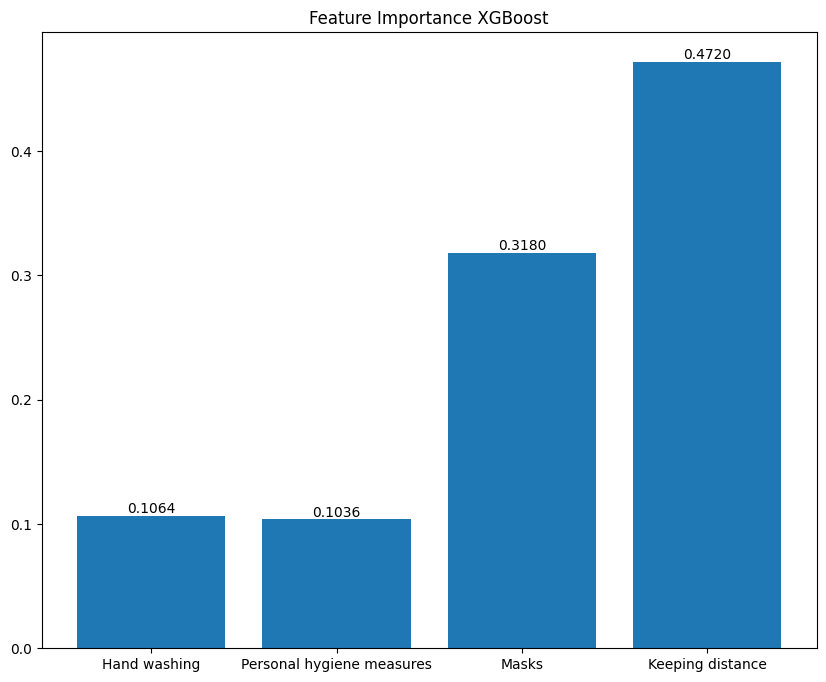

In [79]:
fig, ax = plt.subplots(figsize=(10, 8))
bars = plt.bar(['Hand washing', 'Personal hygiene measures', 'Masks', 'Keeping distance'], average_feature_importances)
plt.title('Feature Importance XGBoost')

# Adding the values above the bars
for bar, importance in zip(bars, average_feature_importances):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{importance:.4f}", ha='center', va='bottom', fontsize=10)

plt.savefig('Feature importance barplot.png')